In [1]:
import sys
sys.path.insert(1, '../')
from scripts.plot_utils import *
from scripts.preprocessing import *
#from scripts.clustering_utils import *
from scripts.biomass_transport import *
from omegaconf import OmegaConf

import joblib
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

from cartopy.feature import OCEAN, RIVERS
import matplotlib.patheffects as pes
import numpy as np
from matplotlib.lines import Line2D
from cmap import Colormap

%load_ext autoreload 
%autoreload 2

cfg = OmegaConf.load('../configs/glob_config.yaml')

In [2]:
def plot_num_filaments(ax, region, colors):

    dataset = compute_number_filaments(region)
    for l, c  in zip(dataset.index, colors):
        ax.plot([1, 2, 5, 10, 15], dataset.loc[l], label = l, color = c, marker = 'o')

    #ax.legend()
    ax.set_xlabel('Clustering years', fontsize = 15)
    ax.set_title('Number of pixels labelled as filaments', fontsize = 20)
    ax.set_xticks([1, 2, 5, 10, 15])
    ax.grid()

    return ax
    
def compute_number_filaments(ebu):

    cols = ['1year', '2years', '5years', '10years', '15years']

    mask_path = [f'../sensitivity_test_years/{ebu}/{col}/outputs/filament_masks/' for col in cols]

    regions = read_region_input_files(f'../configs/{ebu}_regions.input')

    groups = obtain_boxes_grouping(regions)

    dataset = pd.DataFrame(index = regions.keys(), columns = cols)
    
    for file, c in zip(mask_path, ['1year', '2years', '5years', '10years', '15years']):
        
        dataset[c] = [np.sum([xr.open_dataarray(os.path.join(file, f"box_{box}.nc")).sum() for box in group]) for group in groups]

    return dataset
    
    

In [8]:
def compute_available_pct(region_folder, years_list):

    regions = read_region_input_files(f'../{region_folder}/regions.input')
    groups = obtain_boxes_grouping(regions)

    region_idxs = []
    year_idxs = []
    for key in regions.keys():
        region_idxs += [key] * 5
        year_idxs += ['1 year', '2 years', '5 years', '10 years', '15 years']

    region_idxs = np.array(region_idxs)
    year_idxs = np.array(year_idxs)

    # Compute number of pixels that are not available because of bathymetry filter
    bathymetry = xr.open_dataarray('../../data/processed/bathymetry.nc')

    # Number of removed points because of bathymetry for each 10x10 square
    bathy_avails = [[(crop_square(bathymetry, box) >= cfg.ref_depth).sum() for box in region] for region in regions.values()]


    pct_values = dict()

    for region, group, masks in zip(regions, groups, bathy_avails):
        
        # binary boxes with mapped cloud cover have already been generated. True = isnan = unavailable
        # in this way we import data where True = notnan
        boxes = [~xr.open_dataset(f'../{region_folder}/outputs/data_availability/box_{n_box}.nc') for n_box in group]

        pct_per_region_over_slices = []

        for year_slice in years_list:
            # Select the year slice used for training
            train_set = [box.sel(time = year_slice) for box in boxes]

            # Compute the number of points that are marked as non nans
            available_points = np.sum([box.sum().to_array() for box in train_set], axis = 0)
            
            # Total count is the total number of points, but the shelf mask has to be removed
            total_count = [(box.count() - mask * len(box.time)).to_array() for box, mask in zip(train_set, masks)]

            # Obtain a single number over the whole dynamical region for chl, sst and eudepth
            total_count = np.sum(total_count, axis = 0)
            pct_per_region_over_slices.append(available_points / total_count * 100)
        
        pct_values[region] = pct_per_region_over_slices

    return pd.DataFrame(np.array(list(pct_values.values())).reshape(15, 3), index= [region_idxs, year_idxs], columns = ['chl', 'sst', 'eudepth'] )

def compute_available_points(region_folder, years_list):

    regions = read_region_input_files(f'../configs/{region_folder}_regions.input')
    groups = obtain_boxes_grouping(regions)

    region_idxs = []
    year_idxs = []
    for key in regions.keys():
        region_idxs += [key] * 5
        year_idxs += ['1 year', '2 years', '5 years', '10 years', '15 years']

    region_idxs = np.array(region_idxs)
    year_idxs = np.array(year_idxs)


    num_values = dict()

    for region, group in zip(regions, groups):
        
        # binary boxes with mapped cloud cover have already been generated. True = isnan = unavailable
        # in this way we import data where True = notnan
        boxes = [~xr.open_dataset(f'../data_availability/{region_folder}/box_{n_box}.nc') for n_box in group]
        
        num_per_region_over_slices = []

        for year_slice in years_list:
            # Select the year slice used for training
            train_set = [box.sel(time = year_slice) for box in boxes]

            # Compute the number of points that are marked as non nans
            available_points = np.sum([box.sum().to_array() for box in train_set], axis = 0)

            num_per_region_over_slices.append(available_points)
        
        num_values[region] = num_per_region_over_slices

    return pd.DataFrame(np.array(list(num_values.values())).reshape(15, 3), index= [region_idxs, year_idxs], columns = ['chl', 'sst', 'eudepth'] )


def plot_availability(ax, availability_df, colors):

    #fig, ax = plt.subplots(figsize = [8, 5])
    lines = []
    for c, style in zip(['chl', 'sst'], ['solid', 'dashed']):

        d = availability_df[c].unstack(0).loc[['1 year', '2 years', '5 years', '10 years', '15 years']].reset_index(drop = True)
        d = d[availability_df.index.get_level_values(0).unique()]
        d.index = [1, 2, 5, 10, 15]

        #if a == ax[1]:
        d.plot(ax = ax,
                color = colors,
                marker = '.',
                linestyle = style, legend = False)

    #else:
        # d.plot(ax = a,
        #     color = colors,
        #     marker = '.', legend = False)

    #ax.set_title(c)
    ax.set_xlabel('Clustering years', fontsize = 15)
    ax.grid()
    ax.set_xticks(d.index)

    lines = [Line2D([0], [0], color="black", linestyle='solid', label = f"Chl-a")] +\
            [Line2D([0], [0], color="black", linestyle='dashed', label = f"SST")]
    
    ax.legend(handles=lines, ncol=2, loc = 'lower right', prop = {'size' : 12})
    # ax.add_artist(leg)

    #ax.legend(handles=handles, bbox_to_anchor=(1., -0.15), ncol=3)

    return ax

In [4]:
years_list = [slice('2003-01-01', '2003-12-31'),
              slice('2003-01-01', '2004-12-31'),
              slice('2003-01-01', '2007-12-31'),
              slice('2003-01-01', '2012-12-31'),
              slice('2003-01-01', '2017-12-31'),]

#pac_availability = compute_available_pct('../pacific', years_list)

In [5]:
pac_num_filaments = compute_number_filaments("pacific")

In [9]:
pac_availability_num = compute_available_points('pacific', years_list)

In [10]:
atl_num_filaments = compute_number_filaments("atlantic")

In [11]:
atl_availability_num = compute_available_points('atlantic', years_list)

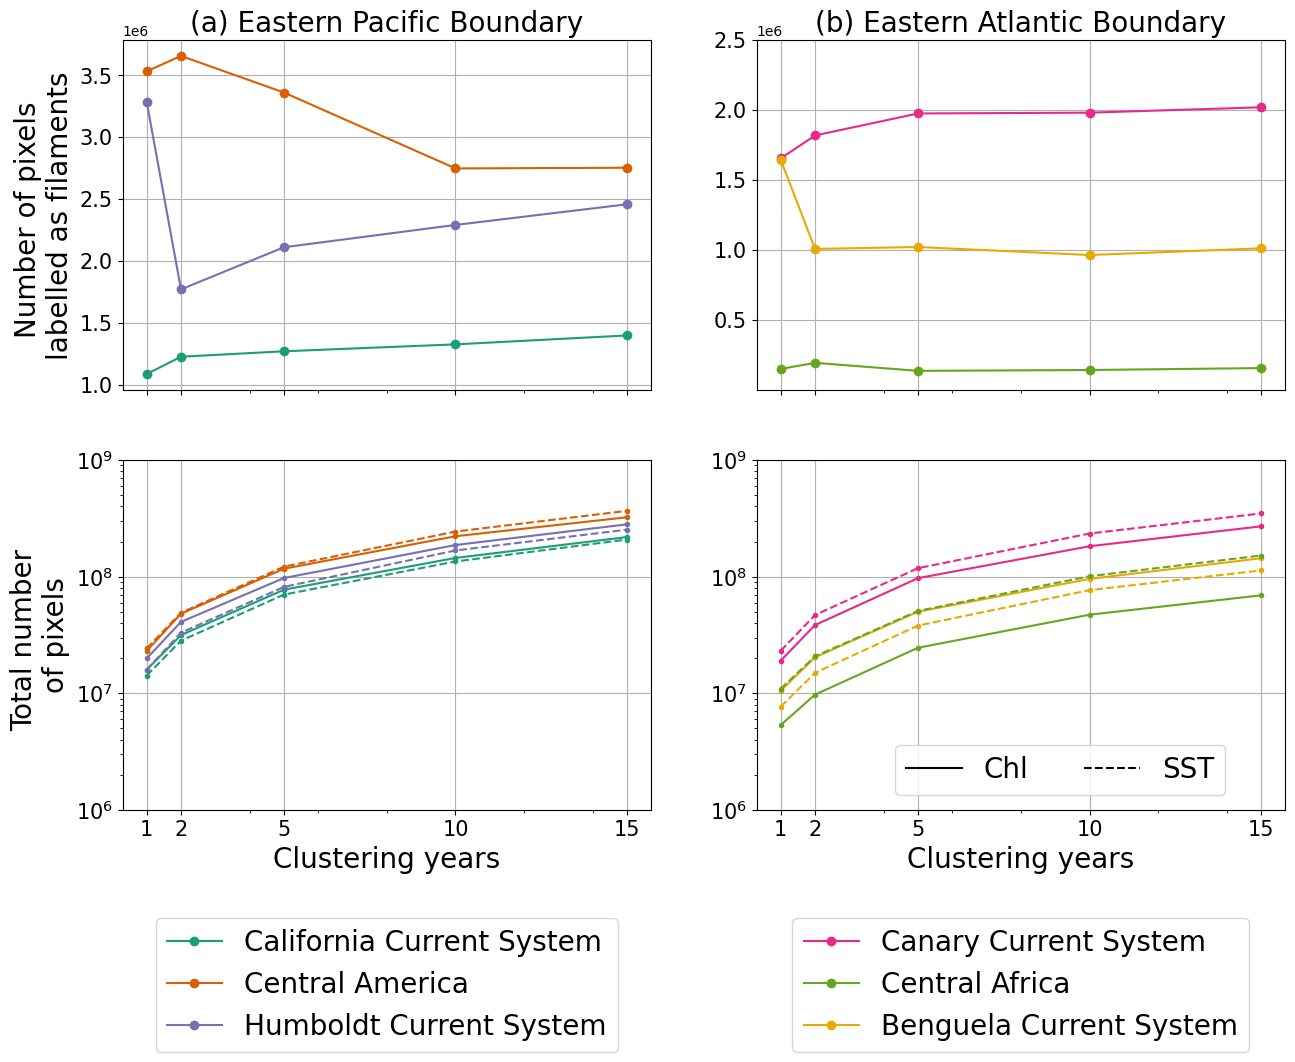

In [12]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = [15,10], sharex = True)
pac_colors = ['#1b9e77', '#d95f02', '#7570b3']
atl_colors = ['#e7298a', '#66a61e', '#e6ab02']

# for a in ax:
#     a.tick_params(labelsize = 12)

#ax[0] = plot_sensitivity_export(ax[0], 'pacific', colors)
ax[0,0] = plot_num_filaments(ax[0,0], 'pacific', pac_colors)
ax[0,1] = plot_num_filaments(ax[0,1], 'atlantic', atl_colors)

# ax[1,1] = plot_availability(ax[0,1], pac_availability_num, pac_colors)
# ax[1,1] = plot_availability(ax[1,1], atl_availability_num, atl_colors)

ax[0,0].set_title('(a) Eastern Pacific Boundary', fontsize = 20)
ax[0,1].set_title('(b) Eastern Atlantic Boundary', fontsize = 20)

ax[0,0].set_ylabel('Number of pixels \nlabelled as filaments', fontsize = 20)
ax[0,1].set_yticks([0.5e6, 1e6, 1.5e6, 2e6, 2.5e6])
ax[0,1].set_ylim([0, 2.5e6])

ax[1,0] = plot_availability(ax[1,0], pac_availability_num, pac_colors)
ax[1,1] = plot_availability(ax[1,1], atl_availability_num, atl_colors)

ax[1,0].set_ylabel('Total number \nof pixels', fontsize = 20)

ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,0].set_ylim([1e6, 1e9])
ax[1,1].set_ylim([1e6, 1e9])

ax[1,0].set_xlabel('Clustering years', fontsize = 20)
ax[1,1].set_xlabel('Clustering years', fontsize = 20)

handles = [Line2D([0], [0], color=color, label = label, marker = 'o') for color, label in zip(pac_colors, pac_availability_num.index.get_level_values(0).unique())] 
ax[1,0].legend(handles=handles, bbox_to_anchor=(0.5, -0.5), loc = 'center', prop = {'size' : 20})

handles = [Line2D([0], [0], color=color, label = label, marker = 'o') for color, label in zip(atl_colors, atl_availability_num.index.get_level_values(0).unique())] 
ax[1,1].legend(handles=handles, bbox_to_anchor=(0.5, -0.5), loc = 'center', prop = {'size' : 20})

ax = ax.ravel()
for a in ax:
    a.tick_params(labelsize = 15)

lines = [Line2D([0], [0], color="black", linestyle='solid', label = f"Chl")] +\
        [Line2D([0], [0], color="black", linestyle='dashed', label = f"SST")]

fig.legend(handles=lines, bbox_to_anchor=(0.75, 0.15), ncol=2, loc = 'center', prop = {'size' : 20})

plt.savefig('images/figure_s2_sensitivity_num_filaments_and_availability.png', bbox_inches = 'tight')

In [ ]:
def compute_seasonality_pct(region_folder):
    regions = read_region_input_files(f'../configs/{region_folder}_regions.input')
    groups = obtain_boxes_grouping(regions)

    table = dict()

    # Compute number of pixels that are not available because of bathymetry filter
    bathymetry = xr.open_dataarray('../../data/processed/bathymetry.nc')

    # Number of removed points because of bathymetry for each 10x10 square
    bathy_avails = [[(crop_square(bathymetry, box) >= cfg.ref_depth).sum() for box in region] for region in regions.values()]

    for bathy, region, group in zip(bathy_avails, regions, groups):
        
        # binary boxes with mapped cloud cover have already been generated. True = isnan = unavailable
        # in this way we import data where True = notnan
        boxes = [~xr.open_dataset(f'../data_availability/{region_folder}/box_{n_box}.nc')[['chl', 'sst']] for n_box in group]

        # Compute the number of points that are marked as non nans
        # Making sure that seasons are in the right order
        available_points =  np.sum(
            [
                box.groupby('time.season')\
                    .sum()\
                    .sel(season = ['DJF', 'MAM', 'JJA', 'SON'])\
                    .sum(['longitude', 'latitude'])\
                    .to_array() for box in boxes
            ], axis = 0       
                                   )
        tot_points = np.sum([box.groupby('time.season')\
                            .count()\
                            .sel(season = ['DJF', 'MAM', 'JJA', 'SON'])\
                            .sum(['longitude', 'latitude'])\
                            .to_array() for box in boxes], axis = 0)
        #print(bathy, available_points)

        
        # bathy_points = np.full(bathy, available_points.shape)
        t = (available_points) / (tot_points) * 100
        # print(available_points.shape)
        table[region] = dict(chl = t[0], sst = t[1])

    arrays = [[region for region in table.keys() for _ in range(2)],
                [var  for _ in range(2) for var in ['chl', 'sst']*len(table.keys())]]
    tuples = list(zip(*arrays))

    index = pd.MultiIndex.from_tuples(tuples, names = ['region', 'var'])

    return pd.DataFrame(np.array([np.array(list(p.values())) for p in table.values()]).reshape(len(arrays[0]),-1), index = index, columns = ['DJF', 'MAM', 'JJA', 'SON'])



In [47]:
compute_seasonality_pct('pacific')

[[72603695 82392180 68803649 94275697]
 [79601384 71148921 49380279 90904125]]
[[172259687 136338572  80778726 104008432]
 [173981842 153671556  82993916 106341109]]
[[124638925 117563678  68227433  85108466]
 [ 97847543 105884577  78075126  66656483]]


DJF        MAM        JJA        SON
region                    var                                            
California Current System chl  22.230702  24.679430  20.609175  28.549291
                          sst  24.373342  21.311669  14.791175  27.528286
Central America           chl  39.558460  30.628741  18.147107  23.622474
                          sst  39.953943  34.522631  18.644754  24.152274
Humboldt Current System   chl  22.898098  21.128738  12.261947  15.463920
                          sst  17.976107  19.029751  14.031790  12.111257

In [48]:
pct_pacific = compute_seasonality_pct('pacific')

[[72603695 82392180 68803649 94275697]
 [79601384 71148921 49380279 90904125]]
[[172259687 136338572  80778726 104008432]
 [173981842 153671556  82993916 106341109]]
[[124638925 117563678  68227433  85108466]
 [ 97847543 105884577  78075126  66656483]]


In [49]:
pct_atlantic = compute_seasonality_pct('atlantic')

[[107965507 112282596  90455054 112971673]
 [140230165 128053080  90338619 132590274]]
[[26208204 36419811 35014917 32689866]
 [59196587 55595823 53876322 47618577]]
[[49829518 63476224 53683942 42287769]
 [35596463 49170573 47957507 28204614]]


In [57]:
def plot_bars(dataframe, fig):
    
    ax = fig.subplots(nrows = 2, sharey = True, sharex = True)
    fig.subplots_adjust(hspace = 0.5)

    dataframe.swaplevel(0,1).loc['chl'].plot.bar(ax = ax[0], color = 'green', legend = False, edgecolor = 'k', alpha = .5)
    ax[0].tick_params(axis = 'y', labelsize = 12)
    ax[0].set_ylim([0, 45])
    ax[0].set_title('Chlorophyll-a concentration', fontsize = 15)

    dataframe.swaplevel(0,1).loc['sst'].plot.bar(ax = ax[1], color = 'red', legend = False, edgecolor = 'k', alpha = .5)
    ax[1].tick_params(axis = 'y', labelsize = 12)
    ax[1].tick_params(axis = 'x', rotation = 0, pad = 40, labelsize = 15)
    ax[1].set_xticks(np.array([i + di for i in range(0, 3) for di in [-0.1875, -0.0625, 0.0625, 0.1875]]), 
                    labels=list(pct_pacific.columns) * 3, 
                    minor = True, 
                    rotation = 90,
                    fontsize = 12)
    ax[1].set_xlabel('')
    ax[1].set_title('Sea surface temperature', fontsize = 15)


    fig.text(0.08, 0.5, 'Percentage of non-nan pixels [%]', va='center', rotation='vertical', fontsize = 15)
    return fig, ax

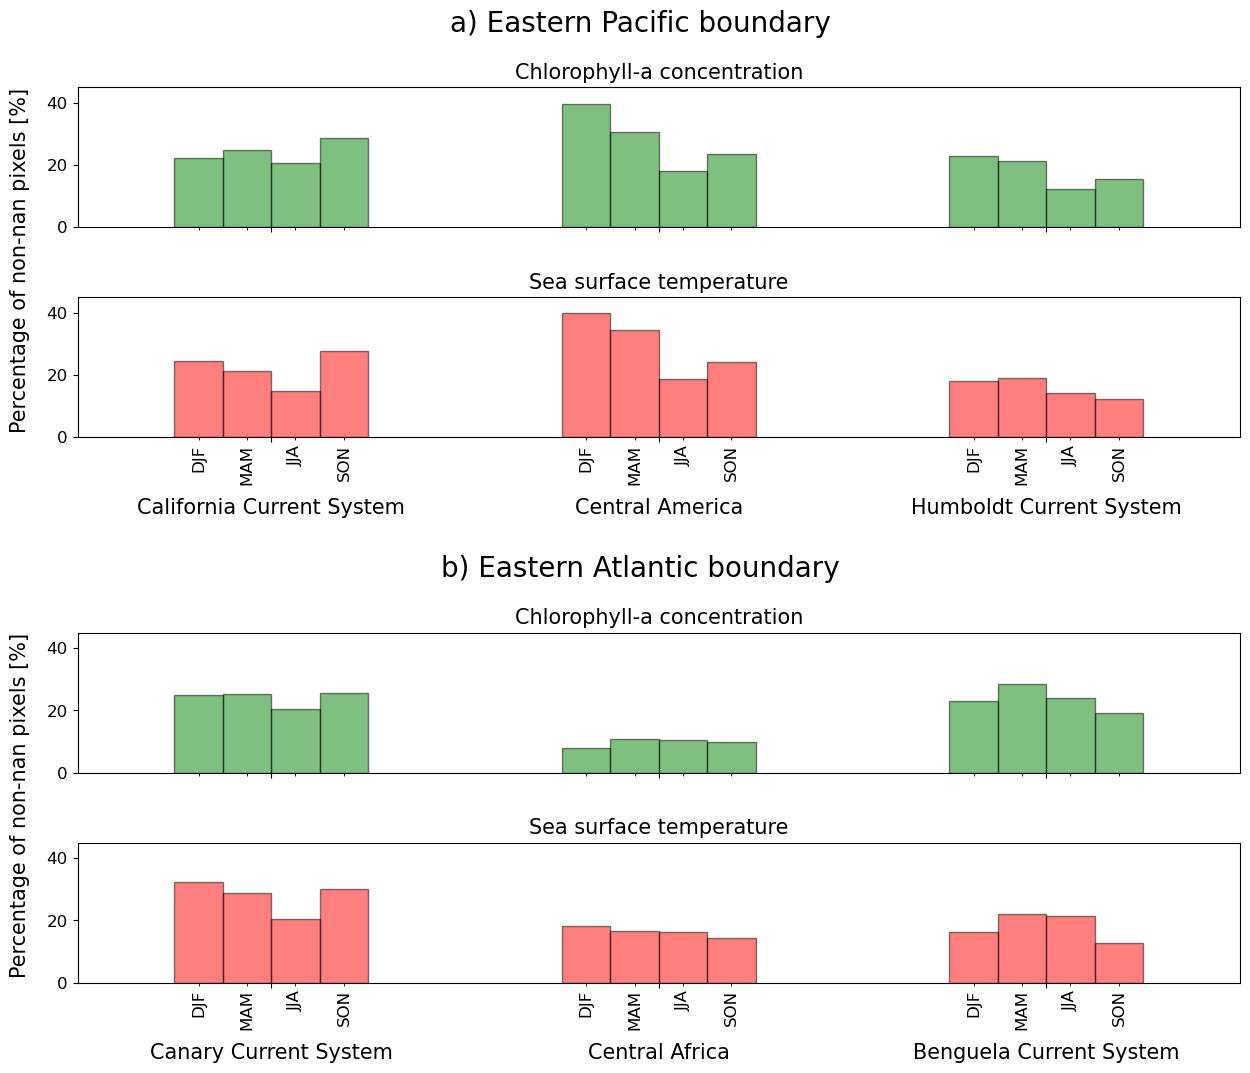

In [58]:
fig = plt.figure(figsize=(15, 10))
subfigs = fig.subfigures(2, 1, wspace=0.5)


plot_bars(pct_pacific, subfigs[0])
subfigs[0].suptitle('a) Eastern Pacific boundary', fontsize = 20, y = 1.05)

plot_bars(pct_atlantic, subfigs[1])
subfigs[1].suptitle('b) Eastern Atlantic boundary', fontsize = 20, y = 1.05)

plt.savefig('images/figure_s6_seasonal_availability.png', bbox_inches = 'tight')